In [1]:
%config InlineBackend.figure_format = 'svg'

In [2]:
import pandas as pd
from pathlib import Path
from numpy import trapezoid
from scipy.interpolate import interp1d

In [3]:
newport = pd.read_csv("newport.csv")
wavelabs = pd.read_csv("wavelabs.csv")
sims = newport
sims["Wavelabs"] = wavelabs[" Counts"]
sims.columns = ["Wavelength [nm]", "Newport", "Wavelabs"]

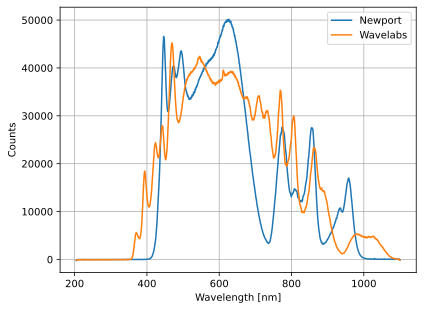

In [4]:
sims.plot(x="Wavelength [nm]", ylabel="Counts", grid=True);

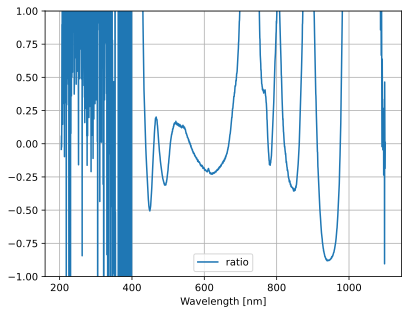

In [5]:
sims["ratio"] = sims["Wavelabs"]/sims["Newport"] -1
sims.plot(x="Wavelength [nm]", y="ratio", ylim=[-1,1], grid=True);

In [6]:
# load up stuff from the mismatch calcs
am15g_filepath = Path("mismatch_factor", "spectrum", "AM1.5G.txt")
am15g = pd.read_csv(am15g_filepath, delimiter='\t')
am15g.columns= ["nm", "gt"] # y was "Global tilt W*m^-2*nm^-1
wl_engineering_filepath = Path("mismatch_factor", "spectrum", "2024-07-10_wavelabs_spectrum_abs.txt")
wl_mismatch_filepath = Path("mismatch_factor", "spectrum", "2024-07-10_wavelabs_spectrum_abs.txt")
wl_engineering = pd.read_csv(wl_mismatch_filepath, delimiter='\t')
wl_engineering.columns = ["wlnm", "wl"]
engineering = wl_engineering
engineering = engineering.join(am15g["nm"].rename("gtnm"), how='right')
engineering = engineering.join(am15g["gt"], how='right')

AM1.5G suns = 1.0003706555734422
Wavelabs suns = 0.8250519353260001


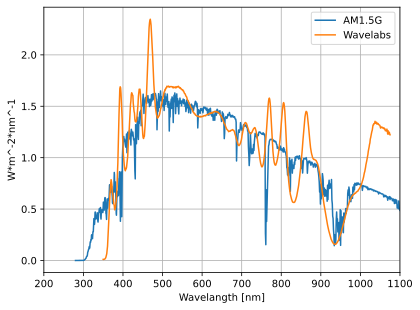

In [7]:
# plot the stuff form mismatch calcs

ax = engineering.plot("gtnm", "gt", label="AM1.5G")
engineering.plot("wlnm", "wl", label="Wavelabs", ax=ax)
ax.set_xlim(200,1100)
ax.set_xlabel("Wavelangth [nm]")
ax.set_ylabel("W*m^-2*nm^-1")
ax.grid(True)
#engineering.plot("gtnm", "gt", label="AM1.5G")
am15g_watts = trapezoid(engineering["gt"].to_numpy(), engineering["gtnm"].to_numpy())
print(f"AM1.5G suns = {am15g_watts/1000}")
wl_watts = trapezoid(wl_engineering["wl"].to_numpy(), wl_engineering["wlnm"].to_numpy())
print(f"Wavelabs suns = {wl_watts/1000}")


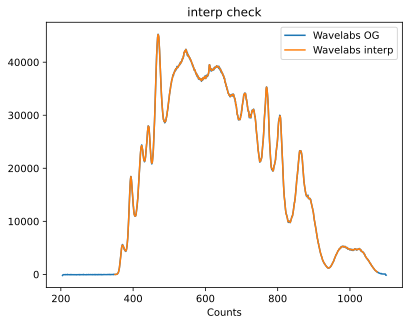

In [8]:
# now work in newport

wl_interper = interp1d(sims["Wavelength [nm]"].to_numpy(), sims["Wavelabs"].to_numpy())
interped_wl_counts = pd.Series(wl_interper(wl_engineering["wlnm"].to_numpy()), name="Wavelabs interp")
engineering = pd.concat([engineering, interped_wl_counts], axis=1)
sims = pd.concat([sims, interped_wl_counts, wl_engineering["wlnm"].rename("nm interp")], axis=1)

np_interper = interp1d(sims["Wavelength [nm]"].to_numpy(), sims["Newport"].to_numpy())
interped_np_counts = pd.Series(np_interper(wl_engineering["wlnm"].to_numpy()), name="Newport interp")
engineering = pd.concat([engineering, interped_np_counts], axis=1)

# check interpolation
ax = sims.plot("Wavelength [nm]", "Wavelabs", label="Wavelabs OG")
sims.plot("nm interp", "Wavelabs interp", ax=ax);
ax.set_xlabel("Counts")
ax.set_title("interp check")

wl_eng_ratio = engineering["wl"] / engineering["Wavelabs interp"]

newport_eng = wl_eng_ratio * engineering["Newport interp"]
newport_eng.name = "np"

engineering = pd.concat([engineering, newport_eng], axis=1)


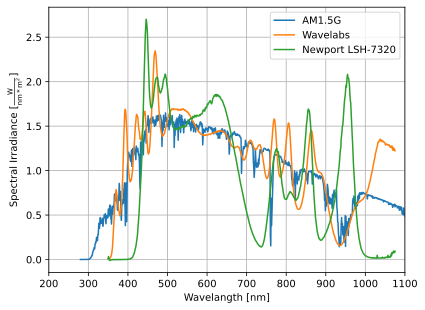

In [9]:
ax = engineering.plot("gtnm", "gt", label="AM1.5G")
engineering.plot("wlnm", "wl", label="Wavelabs", ax=ax)
engineering.plot("wlnm", "np", label="Newport LSH-7320", ax=ax)
ax.set_xlim(200,1100)
ax.set_xlabel("Wavelangth [nm]")
ax.set_ylabel(r"Spectral Irradiance [$\frac{\mathrm{W}}{\mathrm{nm*}\mathrm{m}^2}$]")
ax.grid(True)

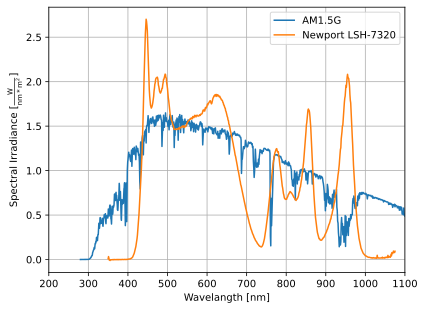

In [10]:
ax = engineering.plot("gtnm", "gt", label="AM1.5G")
engineering.plot("wlnm", "np", label="Newport LSH-7320", ax=ax)
ax.set_xlim(200,1100)
ax.set_xlabel("Wavelangth [nm]")
ax.set_ylabel(r"Spectral Irradiance [$\frac{\mathrm{W}}{\mathrm{nm*}\mathrm{m}^2}$]")
ax.grid(True)